# Лабораторная работа 6: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [4]:
from cvxopt import matrix, solvers

P = matrix([[2.0, 0.0], [0.0, 8.0]])   
q = matrix([-8.0, -16.0])     

G = matrix([[-1.0,1.0,0.0,1.0],[0.0,0.0,-1.0,1.0]])
          
h = matrix([0.0, 3.0, 0.0, 5.0])
A = None
b = None

sol = solvers.qp(P, q, G, h, A, b)
print(sol['x'])    

     pcost       dcost       gap    pres   dres
 0: -3.0512e+01 -3.8829e+01  8e+00  0e+00  2e-01
 1: -3.0792e+01 -3.1146e+01  4e-01  2e-16  5e-03
 2: -3.0982e+01 -3.1024e+01  4e-02  1e-16  4e-04
 3: -3.0997e+01 -3.1003e+01  6e-03  2e-16  5e-17
 4: -3.1000e+01 -3.1000e+01  7e-04  2e-16  3e-17
 5: -3.1000e+01 -3.1000e+01  1e-04  2e-16  4e-17
 6: -3.1000e+01 -3.1000e+01  1e-05  2e-16  3e-17
Optimal solution found.
[ 3.00e+00]
[ 2.00e+00]



pcost: Primal cost значение исходной функции (целевой), которую мы минимизируем.
Она должна подходить к оптимальному значению сверху.

dcost: Dual cost значение двойственной задачи.
Оно должно подходить к оптимальному значению снизу.

gap: Двойственный разрыв.

pres: Primal residual нарушение первичных ограничений.

dres: Dual residual нарушение двойственных условий.

In [5]:
import numpy as np
from scipy.optimize import minimize

def f(x):
    x1, x2 = x
    return -8*x1 -16*x2 + x1**2 + 4*x2**2

# градиент целевой функции
def grad(x):
    x1, x2 = x
    return np.array([-8 + 2*x1, -16 + 8*x2]) # поизводные по x1 и x2

cons = ({'type': 'ineq', 'fun': lambda x: 5 - (x[0] + x[1])}) # ограничение x1 + x2 <= 5

bnds = ((0, 3), (0, None)) # границы

x0 = np.array([1.0, 1.0]) # начальное приближение (внутри области допустимых значений)

res = minimize(f, x0, jac=grad, bounds=bnds, constraints=cons, method='SLSQP', options={'ftol':1e-12})

res, "fun", f(res.x) if res.success else None



(     message: Optimization terminated successfully
      success: True
       status: 0
          fun: -31.0
            x: [ 3.000e+00  2.000e+00]
          nit: 4
          jac: [-2.000e+00  0.000e+00]
         nfev: 5
         njev: 4
  multipliers: [ 0.000e+00],
 'fun',
 np.float64(-31.0))

Активные: х1+х2=5; х1=3.
Неактивные: х1>0; x2>0.

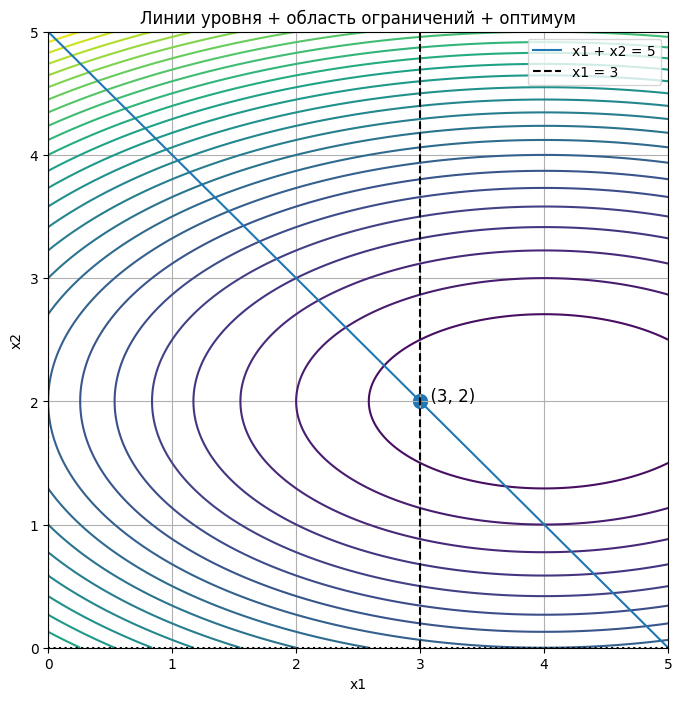

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def f(x1, x2):
    return -8*x1 - 16*x2 + x1**2 + 4*x2**2

x1 = np.linspace(0, 5, 400)
x2 = np.linspace(0, 5, 400)
X1, X2 = np.meshgrid(x1, x2)
Z = f(X1, X2)
x_opt = np.array([3, 2])
plt.figure(figsize=(8, 8))
plt.contour(X1, X2, Z, levels=30) # линии уровня функции
x2_line = 5 - x1
plt.plot(x1, x2_line, label="x1 + x2 = 5") # ограничение
plt.axvline(3, color='black', linestyle='--', label="x1 = 3") 
plt.axvline(0, color='black', linestyle=':') 
plt.axhline(0, color='black', linestyle=':')
plt.scatter(x_opt[0], x_opt[1], s=100)
plt.text(3, 2, "  (3, 2)", fontsize=12) # оптимум

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Линии уровня + область ограничений + оптимум")
plt.legend()
plt.grid(True)

plt.show()


Чем темнее тем меньше значение функции а мы и  ищем минимум.

## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [7]:
# 1 пункт
import numpy as np
from sklearn.svm import SVC

# обучающие данные
X = np.array([[2.5, 0.0], [2.6, 0.1], [ -2.5, 0.0], [-2.6, -0.2]]) 
y = np.array([1,1,-1,-1]) # метки классов для точек

# гиперпараметр SVM:
C = 1.0 
# создаём линейный SVM и обучаем его
svc = SVC(kernel='linear', C=C) 
#kernel='linear' означает, что модель ищет линейную разделяющую гиперплоскость
svc.fit(X, y) # обучаем модель

w = svc.coef_.ravel()
b = svc.intercept_[0] 
sv_idx = svc.support_ # индексы опорных векторов в X
sv = X[sv_idx]

w, b, sv_idx.tolist(), sv.tolist()


(array([0.4, 0. ]), np.float64(-0.0), [2, 0], [[-2.5, 0.0], [2.5, 0.0]])

1) параметры w и b
2) индексы опорных векторов
3) координаты опорных векторов

In [8]:
from cvxopt import matrix, solvers
import numpy as np

def fit_svm_cvxopt(X, y, C=1.0):
    n, d = X.shape
    dim = d + 1 + n # w (d), b (1), xi (n)

    P = np.zeros((dim, dim))
    P[:d, :d] = np.eye(d)
    P = matrix(P.astype(float))

    q = np.hstack([np.zeros(d+1), C*np.ones(n)])
    q = matrix(q.astype(float))

    G_list = []
    h_list = []
    # y_i (w^T x_i + b) >= 1 - xi_i  ->  -y_i w^T x_i - y_i b + xi_i <= -1
    for i in range(n):
        row = np.zeros(dim)
        row[:d] = -y[i]*X[i] 
        row[d] = -y[i] 
        row[d+1+i] = 1.0
        G_list.append(row)
        h_list.append(-1.0)
    # xi_i >= 0 -> -xi_i <= 0
    for i in range(n):
        row = np.zeros(dim)
        row[d+1+i] = -1.0
        G_list.append(row)
        h_list.append(0.0)
    G = matrix(np.vstack(G_list).astype(float))
    h = matrix(np.array(h_list).astype(float))
    sol = solvers.qp(P, q, G, h)
    solx = np.array(sol['x']).reshape(-1)
    w = solx[:d]
    b = solx[d]
    xi = solx[d+1:]
    return w, b, xi


In [9]:
# 2 пункт
import numpy as np
from sklearn.datasets import make_classification, make_circles, make_blobs

# 1. линейно разделимая выборка
X_lin, y_lin = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.5,    # делает выборку легко разделимой линейно
    random_state=0
)
y_lin = 2*y_lin - 1   # переводим метки в {-1,+1}

# 2. разделимые, но не линейно (круги)
X_nlin, y_nlin = make_circles(
    n_samples=200,
    factor=0.3,       # радиус внутреннего круга
    noise=0.05
)
y_nlin = 2*y_nlin - 1

# 3. плохо разделимые классы
X_bad, y_bad = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0.5,    # маленький разделитель → классы сильно перемешаны
    random_state=1
)
y_bad = 2*y_bad - 1

datasets = {
    "linear": (X_lin, y_lin),
    "nonlinear": (X_nlin, y_nlin),
    "bad": (X_bad, y_bad)
}

datasets

{'linear': (array([[ 2.57033369,  0.57084644],
         [-1.97565612,  2.77888341],
         [ 2.38590571,  3.1901946 ],
         [ 2.86581799,  2.57715301],
         [-2.7607126 ,  2.3950888 ],
         [-3.63374202,  2.5081594 ],
         [ 2.5312521 ,  4.70748115],
         [-3.02529436,  2.26508847],
         [-2.37432656,  2.21681344],
         [ 2.09265381,  3.89473735],
         [ 1.81469877,  2.81738748],
         [ 2.7928623 ,  1.84006749],
         [ 2.53231614,  4.16075432],
         [-1.71360694,  2.82166991],
         [-3.63163526,  1.91254111],
         [-3.983329  ,  2.36328673],
         [-1.68493983,  3.30714016],
         [ 2.9175747 ,  1.95478768],
         [-3.78810495,  2.126327  ],
         [ 2.87086528,  3.21398058],
         [-3.58066313,  2.19498639],
         [ 2.73726908,  2.15038823],
         [-1.56718391,  2.74514885],
         [ 1.96335749,  2.23369949],
         [ 2.79534648,  2.18617797],
         [ 2.46542012,  1.6317282 ],
         [-2.1709388 ,  2.25

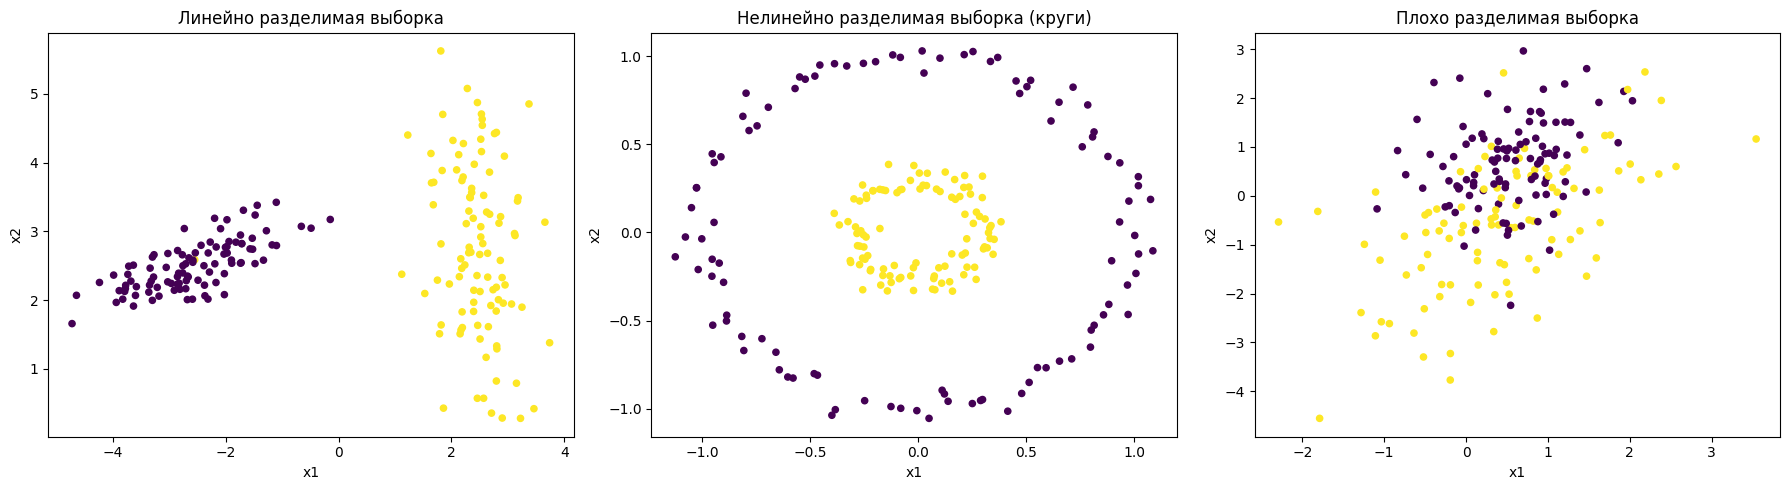

In [11]:
import numpy as np
from sklearn.datasets import make_classification, make_circles
import matplotlib.pyplot as plt

# 1. линейно разделимая выборка
X_lin, y_lin = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.5,
    random_state=0
)
y_lin = 2*y_lin - 1

# 2. нелинейно разделимая выборка 
X_nlin, y_nlin = make_circles(
    n_samples=200,
    factor=0.3,
    noise=0.05
)
y_nlin = 2*y_nlin - 1

# 3. плохо разделимые классы
X_bad, y_bad = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=0.5,
    random_state=1
)
y_bad = 2*y_bad - 1

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1
axes[0].scatter(X_lin[:,0], X_lin[:,1], c=y_lin, s=20)
axes[0].set_title("Линейно разделимая выборка")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

# 2
axes[1].scatter(X_nlin[:,0], X_nlin[:,1], c=y_nlin, s=20)
axes[1].set_title("Нелинейно разделимая выборка (круги)")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")

# 3
axes[2].scatter(X_bad[:,0], X_bad[:,1], c=y_bad, s=20)
axes[2].set_title("Плохо разделимая выборка")
axes[2].set_xlabel("x1")
axes[2].set_ylabel("x2")

plt.tight_layout()
plt.show()


In [1]:
# 3 пункт
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

def plot_svm(X, y, C=1.0):
    svc = SVC(kernel='linear', C=C)
    svc.fit(X, y)

    w = svc.coef_.ravel()
    b = svc.intercept_[0]
    sv = svc.support_

    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    Z = w[0]*xx + w[1]*yy + b

    plt.figure(figsize=(6,6))

    # точки
    plt.scatter(X[:,0], X[:,1], c=y, s=30)

    # опорные вектора (большие точки)
    plt.scatter(X[sv,0], X[sv,1], s=120, facecolors='none')

    # разделяющая прямая
    plt.contour(xx, yy, Z, levels=[0])

    # линии коридора f(x)=±1
    plt.contour(xx, yy, Z, levels=[-1, 1], linestyles='--')

    plt.title(f"Linear SVM, C={C}")
    plt.show()

    return svc

Генерация трех выборок

In [13]:
def generate_linear():
    np.random.seed(0)
    X1 = np.random.randn(30,2) + np.array([2,2])
    X2 = np.random.randn(30,2) + np.array([-2,-2])
    X = np.vstack([X1,X2])
    y = np.hstack([np.ones(30), -np.ones(30)])
    return X, y


In [14]:
def generate_nonlinear():
    np.random.seed(1)
    r1 = np.random.randn(40,2)*0.5
    r2 = np.random.randn(40,2)*0.5 + np.array([3,0])
    X = np.vstack([r1, r2])
    y = np.hstack([-np.ones(40), np.ones(40)])
    return X, y


In [15]:
def generate_bad():
    np.random.seed(2)
    X = np.random.randn(80,2)
    y = np.sign(X[:,0] + 0.3*np.random.randn(80))
    y[y==0] = 1
    return X, y


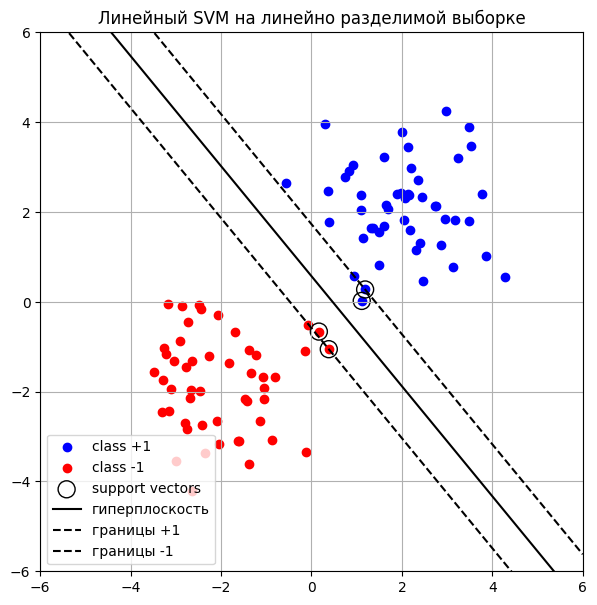

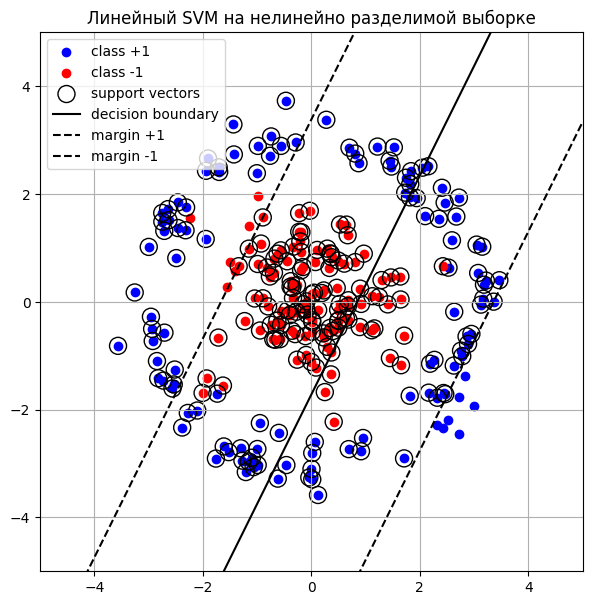

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

np.random.seed(0)
N = 50
X1 = np.random.randn(N, 2) + np.array([2, 2])
X2 = np.random.randn(N, 2) + np.array([-2, -2])

X = np.vstack((X1, X2))
y = np.hstack((np.ones(N), -np.ones(N)))

C = 1.0
clf = SVC(kernel='linear', C=C)
clf.fit(X, y)

w = clf.coef_[0]
b = clf.intercept_[0]
sv = clf.support_

def f_line(x):
    return -(w[0]*x + b)/w[1]

def f_margin_plus(x):
    return -(w[0]*x + b - 1)/w[1]

def f_margin_minus(x):
    return -(w[0]*x + b + 1)/w[1]

plt.figure(figsize=(7,7))

plt.scatter(X1[:,0], X1[:,1], color="blue", label="class +1")
plt.scatter(X2[:,0], X2[:,1], color="red", label="class -1")

plt.scatter(X[sv, 0], X[sv, 1], s=150, facecolors='none', edgecolors='black', label="support vectors")

xx = np.linspace(-6, 6, 200)
plt.plot(xx, f_line(xx), 'k-', label="гиперплоскость")
plt.plot(xx, f_margin_plus(xx), 'k--', label="границы +1")
plt.plot(xx, f_margin_minus(xx), 'k--', label="границы -1")

plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.legend()
plt.title("Линейный SVM на линейно разделимой выборке")
plt.grid(True)
plt.show()

np.random.seed(1)
N = 120

angles = np.random.uniform(0, 2*np.pi, N)
r = 3 + 0.3*np.random.randn(N)   
X1 = np.vstack([r*np.cos(angles), r*np.sin(angles)]).T

X2 = 0.8*np.random.randn(N, 2)

X = np.vstack((X1, X2))
y = np.hstack((np.ones(N), -np.ones(N)))

C = 1.0
clf = SVC(kernel='linear', C=C)
clf.fit(X, y)

w = clf.coef_[0]
b = clf.intercept_[0]
sv = clf.support_

def f_line(x):
    return -(w[0]*x + b)/w[1]

def f_margin_plus(x):
    return -(w[0]*x + b - 1)/w[1]

def f_margin_minus(x):
    return -(w[0]*x + b + 1)/w[1]

plt.figure(figsize=(7,7))

plt.scatter(X1[:,0], X1[:,1], color="blue", label="class +1")
plt.scatter(X2[:,0], X2[:,1], color="red", label="class -1")

plt.scatter(X[sv, 0], X[sv, 1], s=150, facecolors='none',
            edgecolors='black', label="support vectors")

xx = np.linspace(-5, 5, 200)
plt.plot(xx, f_line(xx), 'k-', label="decision boundary")
plt.plot(xx, f_margin_plus(xx), 'k--', label="margin +1")
plt.plot(xx, f_margin_minus(xx), 'k--', label="margin -1")

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.legend()
plt.grid(True)
plt.title("Линейный SVM на нелинейно разделимой выборке")
plt.show()


 4 пункт

При маленьком C

Модель допускает большие ошибки, даёт разделяющую границу.
Опорных векторов много, потому что почти все точки влияют на решение: и ошибочные, и внутренние.

При большом C

Штрафы за ошибки большие, модель старается полностью разделить данные.
Граница подстраивается сильнее под выборку.
Опорных векторов становится меньше, так как важны только точки, лежащие ближе всего к разделяющей прямой.


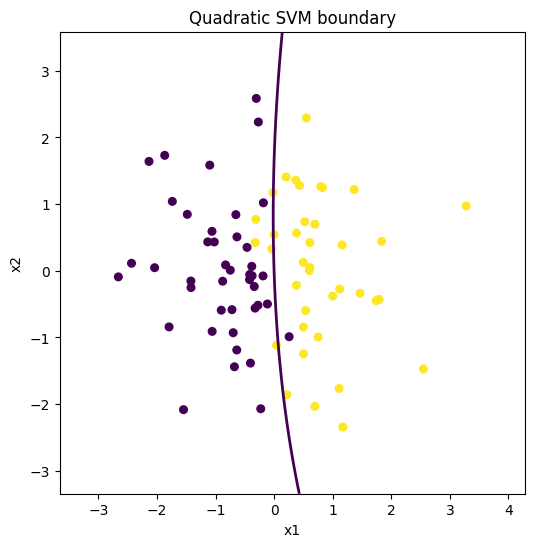

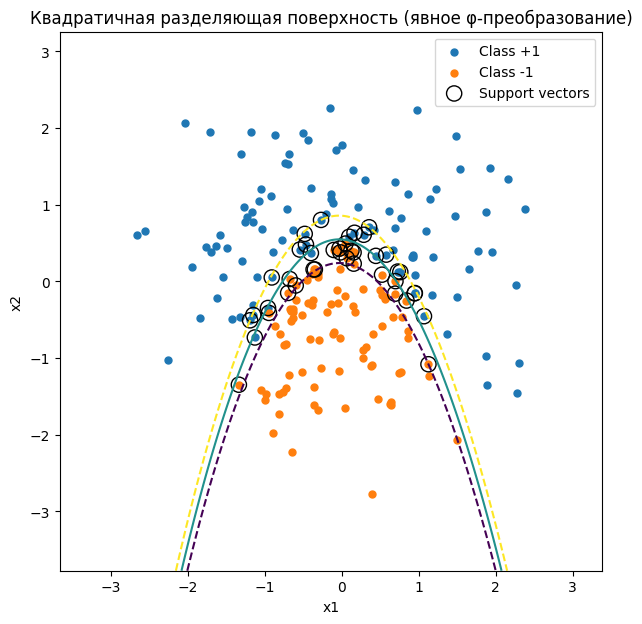

In [ ]:
# 5 пункт
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# генерация плохо разделимой выборки
def generate_bad():
    np.random.seed(2)
    X = np.random.randn(80,2)
    y = np.sign(X[:,0] + 0.3*np.random.randn(80))
    y[y==0] = 1
    return X, y

X, y = generate_bad()

def quad_map(X):
    x1 = X[:,0]
    x2 = X[:,1]
    return np.column_stack([x1, x2, x1**2, x2**2, x1*x2])

Z = quad_map(X)

clf = SVC(kernel='linear', C=1.0)
clf.fit(Z, y)
w = clf.coef_.ravel()
b = clf.intercept_[0]

# визуализация квадратичной границы
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 300),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 300))

grid = np.column_stack([xx.ravel(), yy.ravel()])
grid_z = quad_map(grid)
vals = grid_z.dot(w) + b
vals = vals.reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contour(xx, yy, vals, levels=[0], linewidths=2)
plt.scatter(X[:,0], X[:,1], c=y, s=30)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Quadratic SVM boundary")
plt.show()

np.random.seed(0)
N = 200
X = np.random.randn(N, 2)
y = np.sign(X[:, 0]**2 + X[:, 1] - 0.5)
y[y == 0] = 1

# 2. явное квадратичное φ-преобразование
def phi(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    return np.column_stack([x1, x2, x1**2, x2**2, x1*x2])

X_phi = phi(X)

# 3. обучение линейного SVM в φ-пространстве
clf = SVC(kernel='linear', C=1.0)
clf.fit(X_phi, y)

w = clf.coef_.ravel()
b = clf.intercept_[0]

# 4. визуализация квадратичной границы
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 400),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 400))

grid = np.column_stack([xx.ravel(), yy.ravel()])
grid_phi = phi(grid)

# вычисление значений решающей функции на сетке
Z = (grid_phi @ w + b).reshape(xx.shape)

plt.figure(figsize=(7,7))
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['dashed','solid','dashed'])

plt.scatter(X[y==1,0], X[y==1,1], s=25, label="Class +1")
plt.scatter(X[y==-1,0], X[y==-1,1], s=25, label="Class -1")

# отображение опорных векторов
sv_idx = clf.support_
plt.scatter(X[sv_idx,0], X[sv_idx,1], s=120, facecolors='none', edgecolors='k', label='Support vectors')

plt.title("Квадратичная разделяющая поверхность (явное φ-преобразование)")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


1 Изображение: квадратичная граница на выборке

Точки из выборки окрашены по классам (+1 и -1). Линия уровня f(x)=0 квадратичная разделяющая кривая.
Линейная модель после квадратичного φ-преобразования строит квадратичную разделяющую поверхность, которая способна разделить выборку.

2 Изображение: квадратичная граница на явно нелинейной выборке

Точки двух классов, квадратичная разделяющая кривая (f(x)=0), линии коридора SVM (f(x)=±1) пунктиром и опорные вектора.
После явного φ-преобразования линейный SVM может разделить даже совершенно нелинейно разделимые данные.
Опорные векторы соответствуют точкам, которые на границе.



# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

training: blobs linear_kernel {} C= 1.0


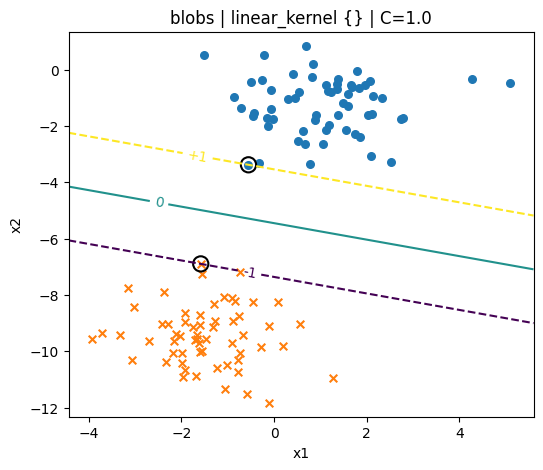

training: blobs poly_kernel {'p': 2} C= 10.0


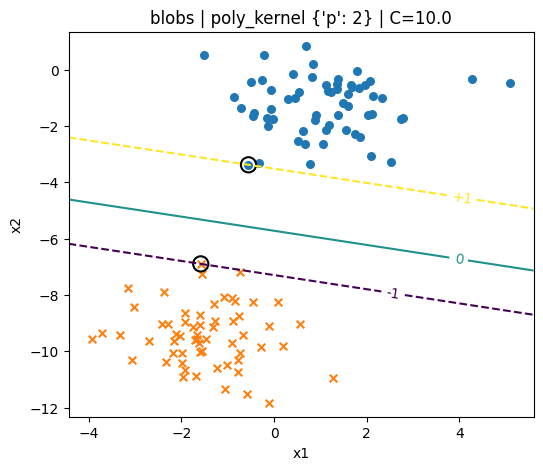

training: circles poly_kernel {'p': 4} C= 10.0


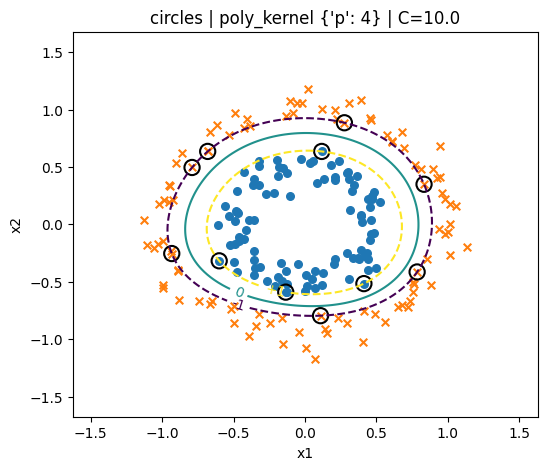

training: circles rbf_kernel {'gamma': 1.0} C= 10.0


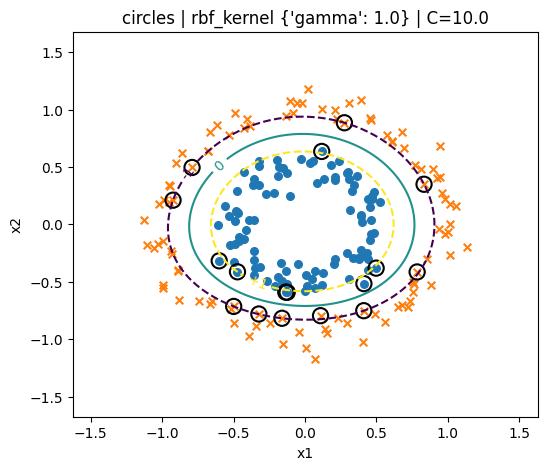

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from scipy.optimize import minimize

# 1, 2 пункт. ядровые функции
def linear_kernel(x, y):
    # матрица скалярных произведений
    return x @ y.T # линейное ядро

def poly_kernel(x, y, p=2):
    return (x @ y.T + 1.0) ** p # полиномиальное ядро

def rbf_kernel(x, y, gamma=1.0):  #Гауссовская-RBF
    x_norm = np.sum(x**2, axis=1)[:, None]
    y_norm = np.sum(y**2, axis=1)[None, :]
    sqdist = x_norm + y_norm - 2 * (x @ y.T)
    return np.exp(-sqdist / (2.0 * gamma))

#обучение kernel-svm через двойственную задачу
def train_kernel_svm(X, y, C=1.0, kernel_fn=None, kernel_params=None, tol=1e-6, maxiter=500):
    """
    решаем двойственную задачу:
      max   sum alpha - 1/2 sum_i,j alpha_i alpha_j y_i y_j k(x_i,x_j)
      s.t.  0 <= alpha_i <= C,  sum_i alpha_i y_i = 0
    используем scipy.optimize.minimize (slsqp) для минимизации отрицательной цели.
    возвращаем модель: alpha, support_idx, b, X, y, kernel_fn, kernel_params, и предвычисленные sv-блоки.
    """
    n = X.shape[0]
    if kernel_params is None:
        kernel_params = {}
    # матрица ядра (n x n)
    K = kernel_fn(X, X, **kernel_params) if kernel_params else kernel_fn(X, X)
    H = np.outer(y, y) * K  # hessian в квадратичной форме

    # цель для минимизации (отрицательная двойственная)
    def objective(alpha):
        return 0.5 * alpha @ H @ alpha - np.sum(alpha)
    def objective_grad(alpha):
        return H @ alpha - np.ones_like(alpha)

    # ограничения и границы
    bounds = [(0.0, C) for _ in range(n)]
    cons = ({'type': 'eq', 'fun': lambda a: np.dot(a, y), 'jac': lambda a: y})

    x0 = np.zeros(n)
    res = minimize(objective, x0, method='SLSQP', jac=objective_grad,
                   bounds=bounds, constraints=cons,
                   options={'ftol':1e-8, 'maxiter':maxiter, 'disp': False})
    alpha = res.x
    alpha[alpha < tol] = 0.0

    # находим опорные векторы
    sv_mask = alpha > tol
    sv_idx = np.where(sv_mask)[0]

    X_sv = X[sv_idx]
    y_sv = y[sv_idx]
    alpha_sv = alpha[sv_idx]

    # вычислим b: усредняем по sv с 0 < альфа < C 
    on_margin = (alpha > tol) & (alpha < C - 1e-8)
    if np.any(on_margin):
        idxs = np.where(on_margin)[0]
    else:
        idxs = sv_idx  #если нет таких, то sv

    if len(idxs) == 0:
        b = 0.0
    else:
        K_sv_all = kernel_fn(X, X[idxs], **kernel_params) if kernel_params else kernel_fn(X, X[idxs])
        S = (alpha * y)[:, None] * K_sv_all
        Ssum = np.sum(S, axis=0)
        b_values = y[idxs] - Ssum
        b = np.mean(b_values)

    model = {
        'alpha': alpha,
        'support_idx': sv_idx,
        'b': b,
        'X': X,
        'y': y,
        'kernel_fn': kernel_fn,
        'kernel_params': kernel_params,
        'X_sv': X_sv,
        'y_sv': y_sv,
        'alpha_sv': alpha_sv
    }
    return model

#функция решения для kernel-svm
def decision_function(model, X_test):
    X_sv = model['X_sv']
    if X_sv.size == 0:
        return np.zeros(X_test.shape[0]) + model['b']
    kernel_fn = model['kernel_fn']
    params = model['kernel_params']
    K = kernel_fn(X_test, X_sv, **params) if params else kernel_fn(X_test, X_sv)
    vals = K @ (model['alpha_sv'] * model['y_sv']) + model['b']
    return vals

#визуализация:  f=0 и уровни ±1
def plot_decision(model, X, y, title=None, mesh_n=150):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx = np.linspace(x_min, x_max, mesh_n)
    yy = np.linspace(y_min, y_max, mesh_n)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = decision_function(model, grid)
    Z = Z.reshape(XX.shape)
    plt.figure(figsize=(6,5))
    # уровни -1, 0, +1
    cs = plt.contour(XX, YY, Z, levels=[-1.0, 0.0, 1.0], linestyles=['--','-','--'])
    plt.clabel(cs, fmt={-1.0: '-1', 0.0: '0', 1.0: '+1'})
    # точки обучающей выборки
    pos = y == 1
    neg = y == -1
    plt.scatter(X[pos,0], X[pos,1], s=30, marker='o')
    plt.scatter(X[neg,0], X[neg,1], s=30, marker='x')
    # выделяем опорные векторы рамкой
    sv_idx = model['support_idx']
    if sv_idx.size > 0:
        plt.scatter(X[sv_idx,0], X[sv_idx,1], s=120, facecolors='none', edgecolors='k', linewidths=1.5)
    plt.title(title if title is not None else 'svm decision boundary')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

#  эксперименты 
if __name__ == '__main__':
    # создаём тестовые датасеты: blobs -близко к линейно-разделимым и circles -нелинейно
    X_blob, y_blob = make_blobs(n_samples=120, centers=2, cluster_std=1.0, random_state=2)
    y_blob = 2*(y_blob)-1  # переводим в ±1
    X_circ, y_circ = make_circles(n_samples=200, factor=0.5, noise=0.08, random_state=3)
    y_circ = 2*(y_circ)-1

    experiments = [
        ('blobs', linear_kernel, {}, 1.0),
        ('blobs', poly_kernel, {'p':2}, 10.0),
        ('circles', poly_kernel, {'p':4}, 10.0),
        ('circles', rbf_kernel, {'gamma':1.0}, 10.0),
    ]

    for dataset_name, kernel_fn, kparams, C in experiments:
        if dataset_name == 'blobs':
            X, y = X_blob, y_blob
        else:
            X, y = X_circ, y_circ
        print('training:', dataset_name, kernel_fn.__name__, kparams, 'C=', C)
        model = train_kernel_svm(X, y, C=C, kernel_fn=kernel_fn, kernel_params=kparams, maxiter=300)
        plot_decision(model, X, y, title=f'{dataset_name} | {kernel_fn.__name__} {kparams} | C={C}')


# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [5]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Pelageya\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\pylab.py:166: UserWarning: pylab import has clobbered these variables: ['clf', 'matrix', 'grid', 'poly']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

C:\Users\Pelageya\AppData\Local\Temp\ipykernel_13736\2390794766.py:16: UserWarning: linewidths is ignored by contourf
  contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')


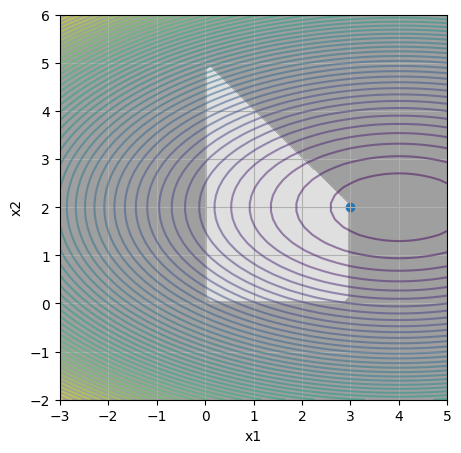

In [6]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [26]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [27]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [5]:
!pip install --upgrade --user cvxopt

  Using cached https://files.pythonhosted.org/packages/16/a0/0d090735e2639a74d6628831e02cc59284e3a3a4f5910f496fc6e435b645/cvxopt-1.2.5-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/56/39/537cb3e4e93f1ac5085dc3b3a43cfd99d0af9b29c44fcaa99490f526b611/mkl-2019.0-py2.py3-none-win_amd64.whl


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [6]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [4]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [6]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [13]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  4e-17  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  8e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  8e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  7e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  9e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  7e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  8e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  2e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [14]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731701274e-06,
 'relative gap': 4.3942774404993765e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 1.1710307819972547e-16,
 'dual infeasibility': 1.9860273225978186e-16,
 'primal slack': 7.131816408857108e-07,
 'dual slack': 1.50695110360481e-08,
 'iterations': 8}

In [19]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [7]:
from sklearn.datasets import make_classification

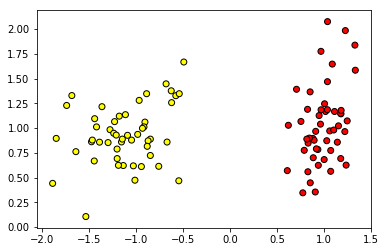

In [10]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

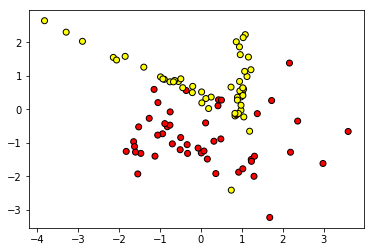

In [11]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

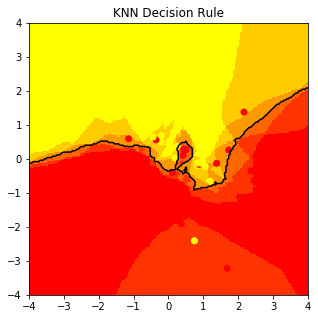

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [13]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [ ]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass